In [48]:
import numpy as np
from docopt import docopt
from matplotlib.colors import Normalize as Norm
from scipy import stats as st
from astropy.io import fits
import math
import time
import numpy as np
from matplotlib import pyplot as plt
plt.ion()
from shesha.util.CovMap_from_Mat import Map_and_Mat,CovMap_from_Cn2, Mat_from_CovMap, DPHI, get_full_index_compass,MapMask_from_validsubs, CovMap_from_Mat
from scipy import stats as st
import glob
from util import Reporter, norm2, norminf,Dataset,Option
import scipy.linalg.lapack as lapack
import scipy.linalg as linalg

In [2]:
# savediction = {'covmapmask':CovMapMask,'telDiam':telDiam,'zenith':zenith,'shnxsub':shnxsub,
# 'r0':r0,'Cn2':Cn2,'l0':l0,'alt':alt,'nwfs':nwfs,'gspos':gspos, 'gsalt':gsalt};
# np.savez("sysconfg.npz",savediction)
sysconfigfile = "../../sysconfg.npz"
npfile = np.load(sysconfigfile)
print(npfile.files)
CovMapMask=npfile['CovMapMask']
telDiam = npfile['telDiam']
zenith = npfile['zenith']
shnxsub = npfile['shnxsub']
r0 = npfile['r0']
Cn2 = npfile['Cn2']
l0 = npfile['l0']
alt = npfile['alt']
nwfs = npfile['nwfs']
gspos = npfile['gspos']
gsalt = npfile['gsalt']
validsubs = npfile['validsubs']

['CovMapMask', 'telDiam', 'zenith', 'shnxsub', 'r0', 'Cn2', 'l0', 'alt', 'nwfs', 'gspos', 'gsalt', 'validsubs']


In [3]:
CovMap_ana = CovMap_from_Cn2(CovMapMask,telDiam,zenith,shnxsub,r0,Cn2,l0,alt,nwfs,gspos,gsalt)
Cmm_ana = Mat_from_CovMap(CovMap_ana,nwfs,validsubs,shnxsub)

Begin calculating Cov Map from Cn2
Cov Map generation finished! Time taken = 3.3 seconds.
computation of Transformation Matrices took 0.2 seconds!
computation of Cov Mat took 4.6 seconds!


In [4]:
class Optsovler:
    def __init__(self,nwfs,alt,X0,n_valid):
        m = getAshape(nwfs) * n_valid * 3 # xx xy yy
        m = int(m)
        n = alt.shape[0]
        n = int(n)
        self.A = np.zeros((m,n))
        self.b = np.zeros(m)
        self.x_k = np.random.rand(n)
        self.x_sol = np.zeros(n)
        self.wfsrow = n_valid
def getAshape(nwfs):
    return int((nwfs+1)*nwfs/2)

In [5]:
def LM(dataset, rpt, option):
    # load information
    A, b, x_sol, x_init, As = dataset.A.copy(), dataset.b.copy(), dataset.x_sol.copy(), \
                              dataset.x_init.copy(), dataset.As.copy()
    datapass, importance, constrained = option.datapass, option.importance, option.constrained
    batchsize = option.batchsize
    lm = option.lm
    timeout = option.timeout
    # remove equation where all 0
    valididx = np.where(b != 0)
    A = A[valididx]
    b = b[valididx]
    As = As[valididx]
    rows = A.shape[0]
    M = A.shape[0]
    N = x_init.shape[0]
    if not lm:
        maxiter = datapass * M // batchsize
    else:
        maxiter = datapass
    rpt.registervar('lr')
    rpt.registervar('gnorm')
    rpt.registervar('chi2')
    rpt.registervar('thresvec')
    rpt.registervar('threstime')
    rpt.registervar('epochaccutime')
    rpt.registervar('error')
    rpt.registervar('algosol')
    rpt.error.append(1.)
    rpt.gnorm.append(1.)
    rpt.chi2.append(1.)
    rpt.gdenom = norminf(A.T @ (A @ x_init - b))
    rpt.chi2denom = norm2((A @ x_init - b))
    rpt.errordenom = norm2(x_init - x_sol)
    rpt.epochaccutime.append(0.0)
    x_new = x_init.copy()
    x_real = x_init.copy()
    eps1 = 1e-16
    eps2 = 1e-16
    threscnt = 0
    itertime = 0.0
    tau = 1.0
    k = 0
    s1 = time.time()
    if lm:
        randidx = np.arange(M)
    else:
        if not importance:
            randidx = np.random.randint(low=0, high=A.shape[0],size=batchsize)
        else:
            randidx = np.random.choice(A.shape[0],batchsize,p=As)

    g =  (A[randidx].T @ (A[randidx]@x_init - b[randidx]))
    h = A[randidx].T @ A[randidx]
    Scur = np.linalg.norm(A[randidx]@x_init-b[randidx])**2
    gnorm = np.linalg.norm(g, ord = np.inf)
    found = gnorm < eps1
    mu = 1 * np.max(np.diag(h))
    x_real = x_init.copy()
    x_new = x_init.copy()
    e1 = time.time()
    v = 2
    itertime += e1-s1
    while not found and k < maxiter:
        s1 = time.time()
        if not lm:
            if not importance:
                randidx = np.random.randint(low=0, high=A.shape[0], size=batchsize)
            else:
                randidx = np.random.choice(A.shape[0], batchsize, replace=False, p=As)
        k += 1
        tmpA = h + mu * np.identity(x_init.shape[0])
        L, info = lapack.dpotrf(tmpA, lower=1)
        assert(info == 0)
        sol = linalg.solve_triangular(L, -g, lower=1)
        hlm = linalg.solve_triangular(L.T, sol, lower=0)
        if(np.linalg.norm(hlm) < eps2*(np.linalg.norm(x_real)+eps2)):
            found = True
        else:
            for i in range(N):
                x_new[i] += hlm[i]
                if constrained:
                    x_new[i] = max(x_new[i], 0.0001)
            Scurnew = np.linalg.norm(A[randidx]@x_new-b[randidx])**2
            rho = (Scur - Scurnew) / (0.5 * hlm.T @ ( mu * hlm - g))
            if rho > 0:
                x_real = x_new.copy()
                g = (A[randidx].T @ (A[randidx]@x_real - b[randidx]))
                h = A[randidx].T @ A[randidx]
                Scur = Scurnew
                found = np.linalg.norm(g, ord=np.inf) < eps1
                mu = mu * max(1/3., 1 - (2*rho-1)**3)
                v = 2
            else:
                x_new = x_real.copy()
                mu = mu * v
                v = 2*v
        e1 = time.time()
        itertime += e1 - s1
        itererr = norm2(x_real - x_sol) / rpt.errordenom
        if threscnt < len(option.threshold) and itererr < option.threshold[threscnt]:
            rpt.thresvec.append(x_real.tolist())
            rpt.threstime.append(itertime)
            threscnt += 1
        rpt.epochaccutime.append(itertime)
        rpt.error.append(norm2(x_real - x_sol) / rpt.errordenom)
        tmpgrad = A.T @ (A @ x_real - b)
        rpt.gnorm.append(norminf(tmpgrad) / rpt.gdenom)
        rpt.chi2.append(norm2(A @ x_real - b) / rpt.chi2denom)
        if itertime > timeout:
            print(k)
            break
    rpt.algosol = list(x_real.copy())


In [6]:
def conf_to_Am1 (telDiam,zenith,validsubs,shnxsub,r0,l0,alt,nwfs,gspos,gsalt,timedelay=0,windspeed=[],winddir=[]):
    dtor   = np.pi/180
    astor  = dtor/60/60
    zenith = zenith*dtor
    gspos  = gspos*astor
    subAperSize = telDiam/shnxsub
    r0     = r0*math.cos(zenith)**0.6
    gsalt  = gsalt/math.cos(zenith)
    alt    = alt/math.cos(zenith)
    #Cn2    = Cn2/np.sum(Cn2)
    l0     = np.where(l0>1000,1000,l0)
    windflag = 0 if timedelay==0 else 1
    if windflag :
        print("Temporal evolution enabled!")
        windspeed   = np.array(windspeed)
        winddir     = np.array(winddir)*dtor
        windspeed_x = windspeed*np.cos(winddir)
        windspeed_y = windspeed*np.sin(winddir)
    #validsubs  = get_full_index_compass()
    CovMapMask = MapMask_from_validsubs(validsubs,shnxsub)
    #CovMapMask = np.tile(CovMapMask,[nwfs*2,nwfs*2])
    #CovMap_ana = np.zeros(CovMapMask.shape)
    validmask  = np.where(CovMapMask.flatten())[0]
    x0 = y0    = np.arange(-shnxsub+1,shnxsub,1)
    X0,Y0      = np.meshgrid(x0,y0) ## 79*79
    X0         = X0*subAperSize
    Y0         = Y0*subAperSize
    n_deltaY   = Y0.shape[0]
    k         = 1/subAperSize/subAperSize
    lambda2   = (0.5e-6/2/np.pi/astor)**2
    time_start = time.time()
    print("Begin calculating Cov Map from Cn2")
    optsolver = Optsovler(nwfs, alt, X0,validmask.shape[0])
    #print(Cn2)
    #optsolver.x_sol = Cn2
    optcnt = 0
    # print(optsolver.A.shape)
    for wfs_1 in range(nwfs):
        for wfs_2 in range(wfs_1,nwfs):
            #print("begin calculating for WFS # "+str(wfs_1)+" and WFS #"+str(wfs_2)+" !")
            gsalt_1 = gsalt[wfs_1]
            gsalt_2 = gsalt[wfs_2]
            for li in range(alt.shape[0]):
                tmpoptcnt = optcnt
                # print(tmpoptcnt)
                layer_alt = alt[li]
                l0_i      = l0[li]
                #Cn2h      = r0**(-5/3.)*Cn2[li]
                dx_li_wind= 0
                dy_li_wind= 0
                if windflag :
                    dx_li_wind = windspeed_x[li] * timedelay
                    dy_li_wind = windspeed_y[li] * timedelay
                #print("Processing altitude = "+str(layer_alt)+" m")
                if gsalt_1*gsalt_2 == 0:
                    if gsalt_1 == gsalt_2:
                        # 2 NGS
                        Xi = X0 - layer_alt*(gspos[wfs_2,0]-gspos[wfs_1,0]) - dx_li_wind
                        Yi = Y0 - layer_alt*(gspos[wfs_2,1]-gspos[wfs_1,1]) - dy_li_wind
                        # no need to scale subAperSize
                        subAperSize_i = subAperSize
                    else:
                        # 1 NGS 1 LGS
                        raise Exception('Cov Map between LGS and NGS is not valid!')
                else:
                    # 2 LGS
                    # Average gsalt is used here, which is not precise
                    if gsalt_1<layer_alt or gsalt_2<layer_alt:
                        raise Exception('Turbulence layer is higher than LGS altitude!')
                    else:
                        avg_gsalt = (gsalt_1+gsalt_2)/2
                        Xi = (1-layer_alt/avg_gsalt)*X0 - layer_alt*(gspos[wfs_2,0]-gspos[wfs_1,0]) - dx_li_wind
                        Yi = (1-layer_alt/avg_gsalt)*Y0 - layer_alt*(gspos[wfs_2,1]-gspos[wfs_1,1]) - dy_li_wind
                        subAperSize_i = (1-layer_alt/avg_gsalt)*subAperSize
            
                Cov_XX = (-2 * DPHI(Xi,Yi,l0_i) + DPHI(Xi+subAperSize_i,Yi,l0_i) + DPHI(Xi-subAperSize_i,Yi,l0_i))*0.5
                optxxA = Cov_XX * k * lambda2 * r0 **(-5/3.) # for opt genreate A, xx
                #Cov_XX = Cov_XX *k*lambda2*np.abs(Cn2h)
                optAstart = tmpoptcnt*optsolver.wfsrow
                optAend = (tmpoptcnt+1)*optsolver.wfsrow
                # print(optAstart)
                optxxA = optxxA.flatten()[validmask]
                optsolver.A[optAstart:optAend,li] = optxxA
                
                #optsolver.b[optAstart:optAend] = Cov_XX.flatten()
                tmpoptcnt += 1
                Cov_YY = (-2 * DPHI(Xi,Yi,l0_i) + DPHI(Xi,subAperSize_i+Yi,l0_i) + DPHI(Xi,-subAperSize_i+Yi,l0_i))*0.5
                optyyA = Cov_YY * k * lambda2 * r0 **(-5/3.) # for opt genreate A, yy
                #Cov_YY = Cov_YY *k*lambda2*np.abs(Cn2h)
                optAstart = tmpoptcnt*optsolver.wfsrow
                # print(optAstart)
                optAend = (tmpoptcnt+1)*optsolver.wfsrow
                optyyA = optyyA.flatten()[validmask]
                optsolver.A[optAstart:optAend,li] = optyyA
                #optsolver.b[optAstart:optAend] = Cov_YY.flatten()
                Cov_XY = -DPHI(Xi+np.sqrt(2)*subAperSize_i/2,Yi-np.sqrt(2)*subAperSize_i/2,l0_i) +\
                          DPHI(Xi+np.sqrt(2)*subAperSize_i/2,Yi+np.sqrt(2)*subAperSize_i/2,l0_i) +\
                          DPHI(Xi-np.sqrt(2)*subAperSize_i/2,Yi-np.sqrt(2)*subAperSize_i/2,l0_i) -\
                          DPHI(Xi-np.sqrt(2)*subAperSize_i/2,Yi+np.sqrt(2)*subAperSize_i/2,l0_i)
                Cov_XY = Cov_XY/4
                optxyA = Cov_XY * k * lambda2 * r0 **(-5/3.) # for opt genreate A, xy
                #Cov_XY = Cov_XY *k*lambda2*np.abs(Cn2h)
                tmpoptcnt += 1
                optAstart = tmpoptcnt*optsolver.wfsrow
                # print(optAstart)
                optAend = (tmpoptcnt+1)*optsolver.wfsrow
                optxyA = optxyA.flatten()[validmask]
                optsolver.A[optAstart:optAend,li] = optxyA
                #optsolver.b[optAstart:optAend] = Cov_XY.flatten()

                #CovMap_ana[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY] += Cov_XX
                #CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)] += Cov_YY
                #CovMap_ana[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)] += Cov_XY
                #CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY] += Cov_XY
            
            '''
            tmpoptcnt = optcnt
            optAstart = tmpoptcnt*optsolver.wfsrow
            optAend = (tmpoptcnt+1)*optsolver.wfsrow
            optsolver.b[optAstart:optAend] = CovMap_ana[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY].flatten()
            tmpoptcnt += 1 
            optAstart = tmpoptcnt*optsolver.wfsrow
            optAend = (tmpoptcnt+1)*optsolver.wfsrow
            optsolver.b[optAstart:optAend] = CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)].flatten()
            tmpoptcnt += 1
            optAstart = tmpoptcnt*optsolver.wfsrow
            optAend = (tmpoptcnt+1)*optsolver.wfsrow
            optsolver.b[optAstart:optAend] = CovMap_ana[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY].flatten()
            '''
            optcnt += 3
            

    time_end = time.time()
    #print("Cov Map generation finished! Time taken = %.1f seconds."%(time_end-time_start))
    #hdu = fits.PrimaryHDU(CovMap_ana)
    #hdu.writeto("CovMap_ana_full.fits",overwrite=1)
    #CovMap_ana = CovMap_ana * CovMapMask
    # Am1 = np.linalg.solve(optsolver.A.T@optsolver.A+np.eye(alt.shape[0])*0.0000000,optsolver.A.T)
    Am1 = np.linalg.pinv(optsolver.A.T@optsolver.A)@optsolver.A.T
    return Am1,optsolver

In [7]:
def mat_to_b(CovMat,nwfs,validsubs,shnxsub):
    CovMap,CovMapMask = CovMap_from_Mat(CovMat,nwfs,validsubs,shnxsub)
    CovMapMask = MapMask_from_validsubs(validsubs,shnxsub)
    n_deltaY   = 2*shnxsub-1
    validmask  = np.where(CovMapMask.flatten())[0]
    n_mappoint = validmask.shape[0]
    b          = np.zeros(getAshape(nwfs) * n_mappoint * 3)
    n_counter  = 0
    for wfs_1 in range(nwfs):
        for wfs_2 in range(wfs_1,nwfs):
            b[n_counter*n_mappoint:(n_counter+1)*n_mappoint] = CovMap[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2:n_deltaY*2*wfs_2+n_deltaY].flatten()[validmask]
            n_counter+=1
            b[n_counter*n_mappoint:(n_counter+1)*n_mappoint] = CovMap[n_deltaY*2*wfs_1+n_deltaY:n_deltaY*2*(wfs_1+1),n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)].flatten()[validmask]
            n_counter+=1
            b[n_counter*n_mappoint:(n_counter+1)*n_mappoint] = CovMap[n_deltaY*2*wfs_1:n_deltaY*2*wfs_1+n_deltaY,n_deltaY*2*wfs_2+n_deltaY:n_deltaY*2*(wfs_2+1)].flatten()[validmask]
            n_counter+=1

    return b

In [12]:
Am1,optsolver = conf_to_Am1 (telDiam,zenith,validsubs,shnxsub,r0,l0,alt,nwfs,gspos,gsalt)
numcmmana = np.load("../../cmm_num_long_buffer_T_250_buffer_every_40_start_from_708636.npy")
print(optsolver.A.shape)

Begin calculating Cov Map from Cn2
(509868, 10)


In [14]:
dataset = Dataset()
dataset.A = optsolver.A
optsolver.b = mat_to_b(Cmm_ana,nwfs,validsubs,shnxsub)
dataset.b = optsolver.b
dataset.x_init = np.array([0.54,0.0200,0.0203,0.060000002,0.01000000,0.0500,0.090000,0.04000,0.05000,0.0500])
dataset.x_sol = Cn2
dataset.As = np.linalg.norm(optsolver.A,axis=1)**2

computation of Transformation Matrices took 0.2 seconds!
computation of Cov Maps took 5.7 seconds!


In [15]:
x = Am1@dataset.b
print("Cn2 calculated from analytical Cmat:",x)

Cn2 calculated from analytical Cmat: [0.59000003 0.02       0.04000001 0.06       0.01       0.05
 0.09000001 0.04       0.05       0.05      ]


In [19]:
DATAPASS=100
TIMEOUT=20
DATANAME="analytical"
CONSTRAINED = True
option = Option()
option.setattr('datapass', DATAPASS)
option.setattr('importance',0)
option.setattr('constrained',CONSTRAINED)
option.setattr('timeout',TIMEOUT)
option.setattr('batchsize',0)
xvalscale = 1.0
option.setattr('lm',1)
option.setattr('threshold',[7e-1,2e-1,7e-2,2e-2])
option.setattr('dataset',DATANAME)
lmrpt = Reporter('./results/','LM',DATANAME,option)
LM(dataset, lmrpt, option)

In [20]:
print(lmrpt.error)

[1.0, 0.7086309663383599, 0.6283516246382368, 0.5586107279724828, 0.49537714907204117, 0.4429021945666654, 0.4039573411723448, 0.3758829400166894, 0.338535388932686, 0.30201005246597806, 0.27892381590683163, 0.2504741454641402, 0.2198725970763243, 0.1954570334582668, 0.15331308444361816, 0.08012775590586836, 0.01733971804609092, 0.0008760303105395491, 6.803920671900189e-06, 6.62749449463307e-09, 7.48091807210586e-13, 9.484870701433872e-18, 3.360441064430626e-24, 2.8581112889396425e-23, 2.9792078631396806e-23, 2.9792078631396806e-23, 2.9792078631396806e-23, 2.9792078631396806e-23, 2.9792078631396806e-23, 2.9481480795459346e-23, 2.9481480795459346e-23, 2.9481480795459346e-23, 2.9481480795459346e-23, 2.9481480795459346e-23, 2.9481480795459346e-23, 2.9476091797262604e-23]


In [25]:
dataset = Dataset()
dataset.A = optsolver.A
optsolver.b = mat_to_b(numcmmana,nwfs,validsubs,shnxsub)
dataset.b = optsolver.b
dataset.x_init = np.array([0.54,0.0200,0.0203,0.060000002,0.01000000,0.0500,0.090000,0.04000,0.05000,0.0500])
dataset.x_sol = Cn2
dataset.As = np.linalg.norm(optsolver.A,axis=1)**2

computation of Transformation Matrices took 0.3 seconds!
computation of Cov Maps took 5.6 seconds!


In [26]:
x = Am1@dataset.b
print("Cn2 calculated from analytical Cmat:",x)

Cn2 calculated from analytical Cmat: [ 3.92610353 -8.48023428  6.3091894  -1.27057277  0.07429112  0.03412267
  0.06428821  0.0247871   0.02301117  0.05800552]


In [27]:
DATAPASS=100
TIMEOUT=20
DATANAME="analytical"
CONSTRAINED = True
option = Option()
option.setattr('datapass', DATAPASS)
option.setattr('importance',0)
option.setattr('constrained',CONSTRAINED)
option.setattr('timeout',TIMEOUT)
option.setattr('batchsize',0)
xvalscale = 1.0
option.setattr('lm',1)
option.setattr('threshold',[7e-1,2e-1,7e-2,2e-2])
option.setattr('dataset',DATANAME)
lmrpt = Reporter('./results/','LM',DATANAME,option)
LM(dataset, lmrpt, option)

In [30]:
print(lmrpt.error)

[1.0, 2.602890946553904, 3.05641289806923, 3.282921953142387, 3.528358808618726, 3.7621510470295965, 3.980998227120685, 4.185264123513582, 4.376111884533543, 4.554628040292288, 4.721900250917246, 4.878997250300842, 5.026987059540583, 5.166914656593258, 5.299776249519581, 5.426492614649438, 5.547887010528213, 5.664668228401789, 5.777419226527999, 5.8865919180768795, 5.992508802832892, 6.095371691621292, 6.1952769081181716, 6.292235405079608, 6.38619556700157, 6.4770662964482035, 6.564738289910713, 6.649102032696524, 6.73006176060296, 6.8075452709937885, 6.881509923181771, 6.9519454311936375, 7.018874152727164, 7.082349566313734, 7.142453552279035, 7.199292988765142, 7.252996065542405, 7.303708618478698, 7.351590701246245, 7.39681353823818, 7.439556940945605, 7.480007215471537, 7.518355537878657, 7.554649327880482, 7.588794092717784, 7.620985413855797, 7.651388672289586, 7.680168004722473, 7.707480108293418, 7.733473375666672, 7.758287083841564, 7.782051048619332, 7.804885566470342, 7.82

In [32]:
print(lmrpt.algosol)

[0.4489134652075826, 0.0001, 0.0013441338000801059, 0.08617233590017125, 0.03054398636166341, 0.025219097148587173, 0.0650758030311595, 0.02461298961607532, 0.023009143268413024, 0.05802683959324351]


In [33]:
numcmmana = np.load("../../cmm_num_long_buffer_T_250_buffer_every_40_start_from_17348.npy")

In [34]:
dataset = Dataset()
dataset.A = optsolver.A
optsolver.b = mat_to_b(numcmmana,nwfs,validsubs,shnxsub)
dataset.b = optsolver.b
dataset.x_init = np.array([0.54,0.0200,0.0203,0.060000002,0.01000000,0.0500,0.090000,0.04000,0.05000,0.0500])
dataset.x_sol = Cn2
dataset.As = np.linalg.norm(optsolver.A,axis=1)**2

computation of Transformation Matrices took 0.2 seconds!
computation of Cov Maps took 5.6 seconds!


In [35]:
DATAPASS=100
TIMEOUT=20
DATANAME="analytical"
CONSTRAINED = True
option = Option()
option.setattr('datapass', DATAPASS)
option.setattr('importance',0)
option.setattr('constrained',CONSTRAINED)
option.setattr('timeout',TIMEOUT)
option.setattr('batchsize',0)
xvalscale = 1.0
option.setattr('lm',1)
option.setattr('threshold',[7e-1,2e-1,7e-2,2e-2])
option.setattr('dataset',DATANAME)
lmrpt = Reporter('./results/','LM',DATANAME,option)
LM(dataset, lmrpt, option)

In [36]:
print(lmrpt.error)

[1.0, 1.8076904010280161, 2.0244123958334765, 2.1432042321158624, 2.3111247220279107, 2.5508327087099523, 2.5508327087099523, 2.5508327087099523, 2.5508327087099523, 2.5711290565556753, 2.604562830060519, 2.637957517577879, 2.68535424207582, 2.718129394411388, 2.718129394411388, 2.718129394411388, 2.727392696855427, 2.727392696855427, 2.7362392603656747, 2.7445542791389275, 2.7524819196892625, 2.7601325956801683, 2.76752951273407, 2.774682847252487, 2.7816010632811072, 2.7882921960121156, 2.794764136572243, 2.801024655591488, 2.807081374374844, 2.8129417327921433, 2.8186129647047626, 2.8241020817262887, 2.829415863906638, 2.8345608556953796, 2.839543365773892, 2.8443694696443274, 2.84904501413033, 2.85357562315632, 2.857966704338707, 2.862223456050849, 2.8663508747155255, 2.8703537621547763, 2.8742367328770184, 2.8780042212218775, 2.8816604883115913, 2.88520962877905, 2.888655577254974, 2.89200211460954, 2.8952528739490844, 2.8984113463730696, 2.901480886499334, 2.9044647177675507, 2.9

In [37]:
print(lmrpt.algosol)

[0.5157939607532586, 0.0001, 0.0001, 0.05005333975042752, 0.027287973483568876, 0.03608656350590896, 0.07182791259985911, 0.037876460075496395, 0.03957892052741576, 0.06007368500316139]


In [45]:
numcmmana = np.load("../../cmm_num_long_buffer_T_250_buffer_every_40_start_from_356130.npy")
dataset = Dataset()
dataset.A = optsolver.A
optsolver.b = mat_to_b(numcmmana,nwfs,validsubs,shnxsub)
dataset.b = optsolver.b
#dataset.x_init = np.array([0.54,0.0200,0.0203,0.060000002,0.01000000,0.0500,0.090000,0.04000,0.05000,0.0500])
dataset.x_init = np.random.rand(10)
dataset.x_sol = Cn2
dataset.As = np.linalg.norm(optsolver.A,axis=1)**2
DATAPASS=100
TIMEOUT=20
DATANAME="analytical"
CONSTRAINED = True
option = Option()
option.setattr('datapass', DATAPASS)
option.setattr('importance',0)
option.setattr('constrained',CONSTRAINED)
option.setattr('timeout',TIMEOUT)
option.setattr('batchsize',0)
xvalscale = 1.0
option.setattr('lm',1)
option.setattr('threshold',[7e-1,2e-1,7e-2,2e-2])
option.setattr('dataset',DATANAME)
lmrpt = Reporter('./results/','LM',DATANAME,option)
LM(dataset, lmrpt, option)

computation of Transformation Matrices took 0.2 seconds!
computation of Cov Maps took 5.6 seconds!


In [46]:
print(lmrpt.algosol)

[0.12157392446494293, 0.04661965537434439, 0.40530274383284903, 0.0001, 0.0001, 0.01768498678673711, 0.06953759414159172, 0.030056306695755566, 0.03520364923095014, 0.03456871274766305]


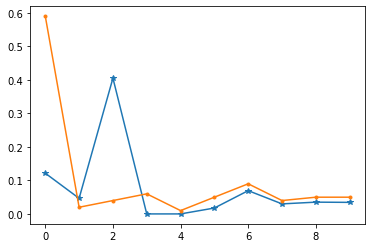

In [47]:
plt.plot(lmrpt.algosol,marker='*')
plt.plot(Cn2,marker='.')